In [22]:
print('hello')

hello


## Imports & Setup

In [23]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import random

# --- 1. SEED EVERYTHING (Để kết quả tái lập được) ---
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()
print("✅ Đã import thư viện và cố định Seed.")

✅ Đã import thư viện và cố định Seed.


## Configuration

In [24]:
class Config:
    def __init__(self):
        # Đường dẫn
        self.TRAIN_DIR = "../data/train/"
        
        # Tham số ảnh
        self.IMG_SIZE = 256
        
        # Chiến lược cắt ảnh: 'resize', 'random', 'smart_roi', 'multiscale_smart'
        self.CROP_STRATEGY = 'multiscale_smart' 
        
        # Tham số Augmentation
        self.ENABLE_AUG = True      # Có bật xoay/lật/nhiễu không
        self.DEBUG_VISUALIZE = True # True thì vẽ ảnh ra xem, False thì chạy ngầm
        
    def __repr__(self):
        return f"Config(Size={self.IMG_SIZE}, Strategy='{self.CROP_STRATEGY}')"

# Tạo một config mặc định
cfg = Config()
print(f"🔧 Cấu hình hiện tại: {cfg}")

🔧 Cấu hình hiện tại: Config(Size=256, Strategy='multiscale_smart')


## Augmentation

In [25]:
# --- 3. AUGMENTATION FACTORY (TUNED - NHẸ NHÀNG HƠN) ---
def get_transforms(cfg):
    transforms_list = []
    
    # --- A. GIAI ĐOẠN 1: RESIZE / CROP ---
    if cfg.CROP_STRATEGY == 'resize':
        transforms_list.append(A.Resize(cfg.IMG_SIZE, cfg.IMG_SIZE))
        
    elif cfg.CROP_STRATEGY == 'random':
        transforms_list.extend([
            A.PadIfNeeded(min_height=cfg.IMG_SIZE, min_width=cfg.IMG_SIZE, border_mode=0, value=0),
            A.RandomCrop(height=cfg.IMG_SIZE, width=cfg.IMG_SIZE, p=1.0)
        ])
        
    elif cfg.CROP_STRATEGY == 'smart_roi':
        transforms_list.extend([
            A.PadIfNeeded(min_height=cfg.IMG_SIZE, min_width=cfg.IMG_SIZE, border_mode=0, value=0),
            A.OneOf([
                A.CropNonEmptyMaskIfExists(height=cfg.IMG_SIZE, width=cfg.IMG_SIZE, p=0.8),
                A.RandomCrop(height=cfg.IMG_SIZE, width=cfg.IMG_SIZE, p=0.2),
            ], p=1.0)
        ])
        
    elif cfg.CROP_STRATEGY == 'multiscale_smart':
        transforms_list.extend([
            # 1. Co giãn nhẹ (chỉ +/- 10% thay vì 20%)
            A.RandomScale(scale_limit=0.1, p=0.5), 
            
            A.PadIfNeeded(min_height=cfg.IMG_SIZE, min_width=cfg.IMG_SIZE, border_mode=0, value=0),
            A.OneOf([
                A.CropNonEmptyMaskIfExists(height=cfg.IMG_SIZE, width=cfg.IMG_SIZE, p=0.8),
                A.RandomCrop(height=cfg.IMG_SIZE, width=cfg.IMG_SIZE, p=0.2),
            ], p=1.0)
        ])

    # --- B. GIAI ĐOẠN 2: AUGMENTATION (Đã giảm nhẹ cường độ) ---
    if cfg.ENABLE_AUG:
        transforms_list.extend([
            # Flip xoay 90 độ là an toàn nhất, giữ nguyên
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            
            # Elastic: Giảm alpha/sigma để không bị méo quá đà
            A.ElasticTransform(alpha=1, sigma=20, alpha_affine=20, p=0.2),
            
            # Dropout: Giảm lỗ thủng xuống nhỏ xíu (max 8px) và ít (max 3 lỗ)
            # Chỉ để mô phỏng bụi bẩn nhỏ, không che mất tế bào
            A.CoarseDropout(max_holes=3, max_height=8, max_width=8, 
                            min_holes=1, min_height=4, min_width=4, 
                            fill_value=0, mask_fill_value=0, p=0.2),

            # Màu sắc: Chỉnh nhẹ độ sáng tối
            A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
            
            # Noise: Giảm var_limit xuống để hạt nhiễu mịn hơn
            A.GaussNoise(var_limit=(10.0, 30.0), p=0.1),
        ])

    # --- C. GIAI ĐOẠN 3: FORMAT ---
    transforms_list.append(ToTensorV2())
    
    return A.Compose(transforms_list)

## Experiments

In [26]:
def run_experiment(config, n_trials=300):
    print(f"\n🧪 Đang chạy thí nghiệm: {config.CROP_STRATEGY.upper()} (Size: {config.IMG_SIZE})...")
    
    transform = get_transforms(config)
    ids = next(os.walk(config.TRAIN_DIR))[1]
    
    # Các biến tích lũy
    total_enrichment = 0 # Tổng hệ số làm giàu
    total_density_crop = 0
    empty_crops = 0
    valid_trials = 0 # Đếm số lần chạy thành công (ảnh gốc có tế bào)
    
    samples = [] 
    
    for _ in tqdm(range(n_trials), desc="Processing"):
        id_ = np.random.choice(ids)
        path = os.path.join(config.TRAIN_DIR, id_)
        
        # Load Ảnh & Mask
        img_path = os.path.join(path, 'images', id_ + '.png')
        mask_dir = os.path.join(path, 'masks')
        
        if not os.path.exists(img_path): continue
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        h, w = img.shape[:2]
        
        # Load mask gộp
        mask = np.zeros((h, w), dtype=np.uint8)
        if os.path.exists(mask_dir):
            for f in next(os.walk(mask_dir))[2]:
                m = cv2.imread(os.path.join(mask_dir, f), 0)
                mask = np.maximum(mask, m)
        
        # 1. TÍNH MẬT ĐỘ GỐC (Original Density)
        orig_nuclei_pixels = np.sum(mask > 0)
        orig_total_pixels = h * w
        # Nếu ảnh gốc đen xì (không có tế bào nào) thì bỏ qua để tránh chia cho 0
        if orig_nuclei_pixels == 0: continue
            
        orig_density = (orig_nuclei_pixels / orig_total_pixels) * 100
        
        try:
            # Apply chiến lược cắt
            aug = transform(image=img, mask=mask)
            res_mask = aug['mask'].numpy()
            res_img = aug['image'].permute(1, 2, 0).numpy()
            
            # 2. TÍNH MẬT ĐỘ ẢNH CẮT (Crop Density)
            crop_nuclei_pixels = np.sum(res_mask > 0)
            crop_total_pixels = config.IMG_SIZE * config.IMG_SIZE
            crop_density = (crop_nuclei_pixels / crop_total_pixels) * 100
            
            # 3. TÍNH HỆ SỐ LÀM GIÀU (Enrichment Factor)
            # Crop / Original
            enrichment = crop_density / (orig_density + 1e-7) # +1e-7 để an toàn
            
            # Tích lũy
            total_enrichment += enrichment
            total_density_crop += crop_density
            valid_trials += 1
            
            if crop_nuclei_pixels == 0:
                empty_crops += 1
                
            if len(samples) < 5:
                samples.append((res_img, res_mask))
                
        except Exception as e:
            # print(f"Error: {e}")
            pass

    if valid_trials == 0: return samples, 0, 0, 0

    # Kết quả trung bình
    avg_density = total_density_crop / valid_trials
    avg_enrichment = total_enrichment / valid_trials
    empty_rate = (empty_crops / valid_trials) * 100
    
    print(f"   => Mật độ thông tin trung bình (Crop): {avg_density:.2f}%")
    print(f"   => Tỷ lệ ảnh rác (Empty): {empty_rate:.1f}%")
    print(f"   => HỆ SỐ LÀM GIÀU THÔNG TIN (Enrichment): {avg_enrichment:.2f} lần") # Chỉ số mới
    
    return samples, avg_density, empty_rate, avg_enrichment

def visualize_results(samples, title):
    if not samples: return
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)
    
    for i, (img, mask) in enumerate(samples):
        # Normalize ảnh về 0-1 để hiển thị đúng
        img = (img - img.min()) / (img.max() - img.min())
        
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Sample {i+1}")
        
        axes[1, i].imshow(mask, cmap='gray')
        axes[1, i].axis('off')
    plt.tight_layout()
    plt.show()

In [27]:
def visualize_comparison_on_single_image(configs, image_id=None):
    """
    So sánh trực quan các chiến lược trên CÙNG MỘT TẤM ẢNH GỐC.
    """
    print("\n🖼️ Đang chuẩn bị Visualize so sánh trên cùng 1 ảnh...")
    
    # 1. TÌM HOẶC LOAD ẢNH
    # Lấy config đầu tiên để tìm đường dẫn
    base_dir = configs[0].TRAIN_DIR
    large_img = None
    large_mask = None
    
    # Nếu không chỉ định ID, tự tìm ảnh to > 400px
    if image_id is None:
        for id_ in next(os.walk(base_dir))[1]:
            img_path = os.path.join(base_dir, id_, 'images', id_+'.png')
            img = cv2.imread(img_path)
            if img is not None and img.shape[0] > 400:
                large_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                image_id = id_
                # Load mask
                h, w = img.shape[:2]
                large_mask = np.zeros((h, w), dtype=np.uint8)
                mask_dir = os.path.join(base_dir, id_, 'masks')
                if os.path.exists(mask_dir):
                    for f in next(os.walk(mask_dir))[2]:
                        m = cv2.imread(os.path.join(mask_dir, f), 0)
                        large_mask = np.maximum(large_mask, m)
                break
    else:
        # Load theo ID chỉ định
        # ... (Code load tương tự như trên)
        pass

    if large_img is None:
        print("⚠️ Không tìm thấy ảnh phù hợp!")
        return

    print(f"✅ Đã chọn ảnh ID: {image_id} (Size: {large_img.shape[:2]})")

    # 2. THIẾT LẬP LƯỚI VẼ
    n_strategies = len(configs)
    n_samples = 5 # Số lần cắt thử mỗi chiến lược
    
    fig = plt.figure(figsize=(15, 3 * n_strategies + 2))
    
    # --- VẼ ẢNH GỐC (Hàng đầu tiên) ---
    ax_orig = plt.subplot2grid((n_strategies + 1, n_samples + 1), (0, 0), colspan=n_samples+1)
    overlay = large_img.copy()
    contours, _ = cv2.findContours(large_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)
    ax_orig.imshow(overlay)
    ax_orig.set_title(f"ẢNH GỐC (Original) - ID: {image_id}", fontweight='bold')
    ax_orig.axis('off')
    
    # --- VẼ CÁC CHIẾN LƯỢC (Các hàng tiếp theo) ---
    for row_idx, cfg in enumerate(configs):
        transform = get_transforms(cfg)
        
        # Cột tiêu đề (Tên chiến lược)
        ax_title = plt.subplot2grid((n_strategies + 1, n_samples + 1), (row_idx + 1, 0))
        name = cfg.CROP_STRATEGY.upper().replace('_', '\n')
        ax_title.text(0.5, 0.5, name, ha='center', va='center', fontsize=12, fontweight='bold')
        ax_title.axis('off')
        
        # Các cột mẫu (Samples)
        for col_idx in range(1, n_samples + 1):
            # Apply transform lên cùng 1 ảnh gốc
            aug = transform(image=large_img, mask=large_mask)
            
            # Xử lý hiển thị
            res_img = aug['image'].permute(1, 2, 0).numpy()
            res_img = (res_img - res_img.min()) / (res_img.max() - res_img.min()) # Normalize 0-1
            res_mask = aug['mask'].squeeze().numpy()
            
            # Overlay
            disp_img = (res_img * 255).astype(np.uint8).copy()
            cnts, _ = cv2.findContours(res_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            cv2.drawContours(disp_img, cnts, -1, (0, 255, 0), 2)
            
            ax = plt.subplot2grid((n_strategies + 1, n_samples + 1), (row_idx + 1, col_idx))
            ax.imshow(disp_img)
            if row_idx == 0: ax.set_title(f"Try #{col_idx}") # Chỉ hiện tiêu đề ở hàng đầu
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

## Main

/tmp/ipykernel_9282/2303953930.py:11: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=cfg.IMG_SIZE, min_width=cfg.IMG_SIZE, border_mode=0, value=0),


🚀 BẮT ĐẦU CHẠY THÍ NGHIỆM SO SÁNH...

🧪 Đang chạy thí nghiệm: RANDOM (Size: 256)...


Processing: 100%|██████████| 500/500 [00:17<00:00, 28.82it/s]
/tmp/ipykernel_9282/2303953930.py:17: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=cfg.IMG_SIZE, min_width=cfg.IMG_SIZE, border_mode=0, value=0),


   => Mật độ thông tin trung bình (Crop): 13.98%
   => Tỷ lệ ảnh rác (Empty): 1.6%
   => HỆ SỐ LÀM GIÀU THÔNG TIN (Enrichment): 1.01 lần

🧪 Đang chạy thí nghiệm: SMART_ROI (Size: 256)...


Processing: 100%|██████████| 500/500 [00:14<00:00, 33.63it/s]
/tmp/ipykernel_9282/2303953930.py:29: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=cfg.IMG_SIZE, min_width=cfg.IMG_SIZE, border_mode=0, value=0),
/tmp/ipykernel_9282/2303953930.py:45: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=20, alpha_affine=20, p=0.2),
/tmp/ipykernel_9282/2303953930.py:49: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=8, max_width=8,
/tmp/ipykernel_9282/2303953930.py:57: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 30.0), p=0.1),


   => Mật độ thông tin trung bình (Crop): 14.48%
   => Tỷ lệ ảnh rác (Empty): 0.4%
   => HỆ SỐ LÀM GIÀU THÔNG TIN (Enrichment): 1.05 lần

🧪 Đang chạy thí nghiệm: MULTISCALE_SMART (Size: 256)...


Processing: 100%|██████████| 500/500 [00:18<00:00, 26.57it/s]


   => Mật độ thông tin trung bình (Crop): 15.10%
   => Tỷ lệ ảnh rác (Empty): 0.0%
   => HỆ SỐ LÀM GIÀU THÔNG TIN (Enrichment): 1.07 lần

STRATEGY             | EMPTY %    | DENSITY %  | ENRICHMENT (x) 
------------------------------------------------------------
RANDOM               | 1.6        | 13.98      | 1.01           
SMART_ROI            | 0.4        | 14.48      | 1.05           
MULTISCALE_SMART     | 0.0        | 15.10      | 1.07           


🖼️ Đang chuẩn bị Visualize so sánh trên cùng 1 ảnh...
✅ Đã chọn ảnh ID: 4e1c889de3764694d0dea41e5682fedb265eaf2cdbe72ff6c1f518747d709464 (Size: (520, 696))


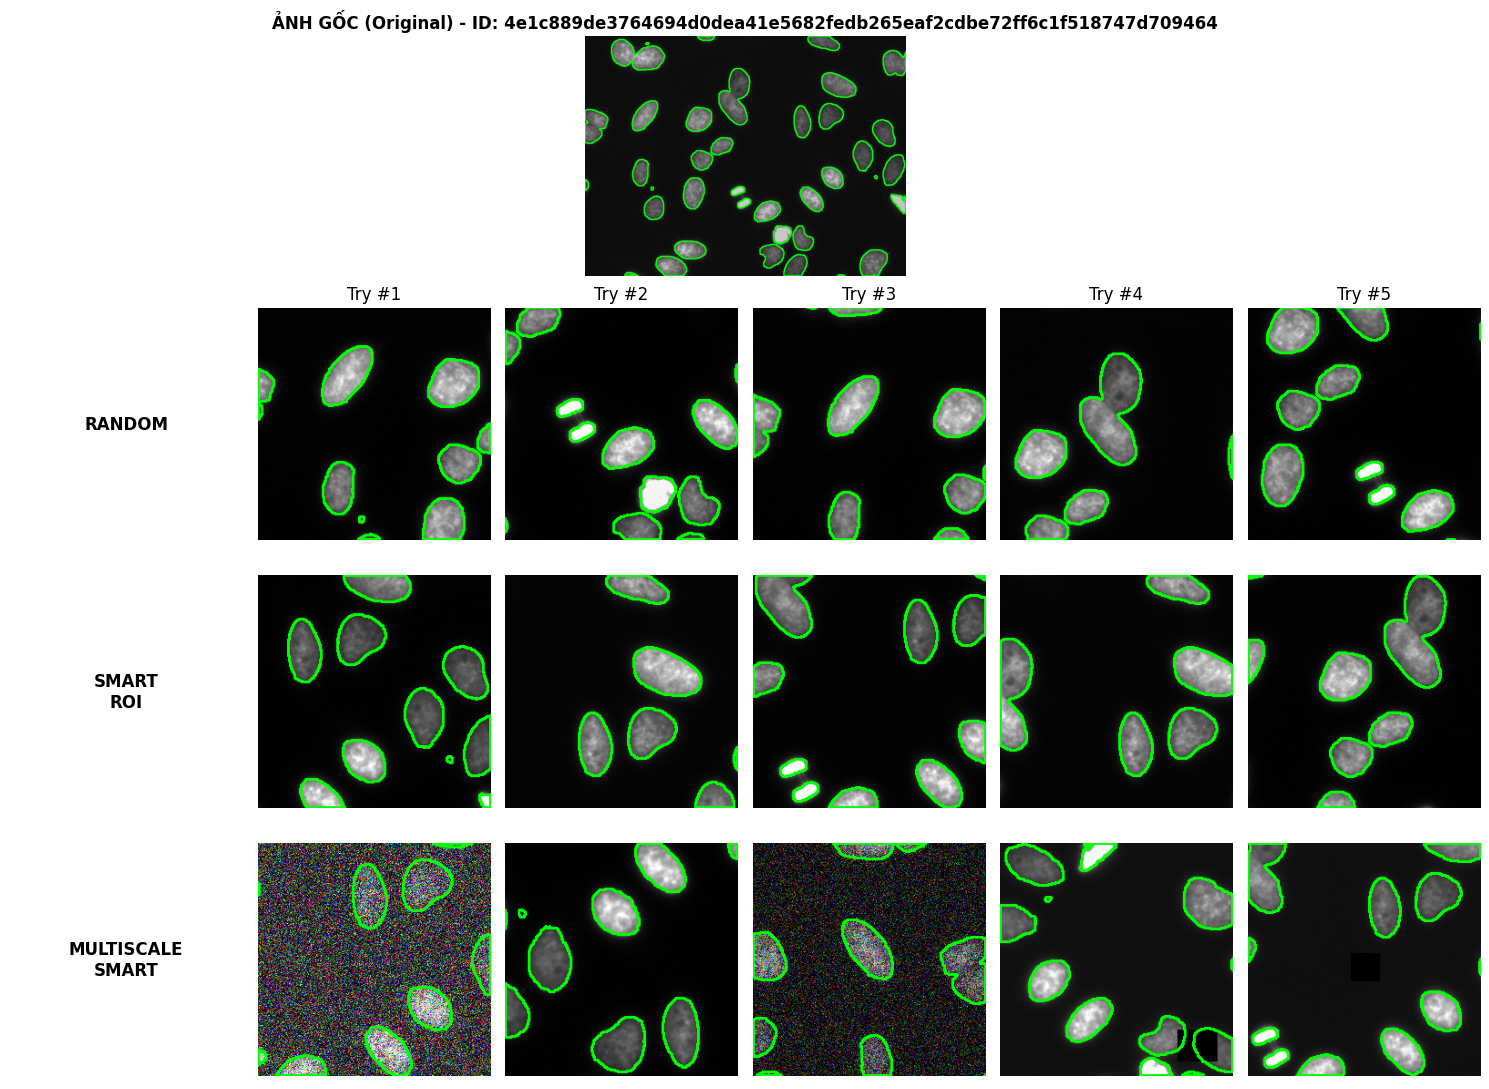

In [28]:
# --- CẤU HÌNH CÁC CHIẾN LƯỢC ---

# 1. Random (Đối chứng)
cfg_random = Config()
cfg_random.CROP_STRATEGY = 'random'
cfg_random.ENABLE_AUG = False 

# 2. Smart ROI (Thông minh cơ bản)
cfg_smart = Config()
cfg_smart.CROP_STRATEGY = 'smart_roi'
cfg_smart.ENABLE_AUG = False

# 3. Multiscale + Dropout (Tối ưu đề xuất)
cfg_best = Config()
cfg_best.CROP_STRATEGY = 'multiscale_smart'
cfg_best.ENABLE_AUG = True 

configs_to_test = [cfg_random, cfg_smart, cfg_best]
results = {}

# --- PHẦN 1: CHẠY THỐNG KÊ SỐ LIỆU ---
print("🚀 BẮT ĐẦU CHẠY THÍ NGHIỆM SO SÁNH...")
for cfg in configs_to_test:
    # Lưu ý: Hàm run_experiment phải là phiên bản mới trả về 4 giá trị (enrichment)
    # samples ở đây là random samples, ta không dùng để vẽ so sánh cùng 1 ảnh
    _, dens, empty, enrich = run_experiment(cfg, n_trials=500)
    
    results[cfg.CROP_STRATEGY] = {
        "density": dens,
        "empty": empty,
        "enrichment": enrich
    }

# In bảng tổng kết
print("\n" + "="*60)
print(f"{'STRATEGY':<20} | {'EMPTY %':<10} | {'DENSITY %':<10} | {'ENRICHMENT (x)':<15}")
print("-" * 60)
for name, res in results.items():
    print(f"{name.upper():<20} | {res['empty']:<10.1f} | {res['density']:<10.2f} | {res['enrichment']:<15.2f}")
print("="*60 + "\n")

# --- PHẦN 2: VISUALIZE TRÊN CÙNG 1 ẢNH ---
# Đây là phần quan trọng nhất để đưa vào báo cáo
visualize_comparison_on_single_image(configs_to_test)

🕵️ Đang quét tìm ảnh có MẬT ĐỘ TẾ BÀO THẤP NHẤT (Lowest Density)...


Scanning Density: 100%|██████████| 670/670 [00:11<00:00, 56.01it/s]
/tmp/ipykernel_9282/2303953930.py:11: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=cfg.IMG_SIZE, min_width=cfg.IMG_SIZE, border_mode=0, value=0),
/tmp/ipykernel_9282/2303953930.py:17: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=cfg.IMG_SIZE, min_width=cfg.IMG_SIZE, border_mode=0, value=0),
/tmp/ipykernel_9282/2303953930.py:29: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=cfg.IMG_SIZE, min_width=cfg.IMG_SIZE, border_mode=0, value=0),
/tmp/ipykernel_9282/2303953930.py:45: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=20, alpha_affine=20, p=0.2),
/tmp/ipykernel_9282/2303953930.py:49: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_valu


✅ Đã tìm thấy 'HOANG MẠC' (Ảnh thưa nhất):
   🆔 ID: 866a8cba7bfe1ea73e383d6cf492e53752579140c8b833bb56839a55bf79d855
   📉 Mật độ: 0.6559% (Cực thấp!)
   📏 Kích thước: 520x696
   ⚪ Tổng pixel tế bào: 2374


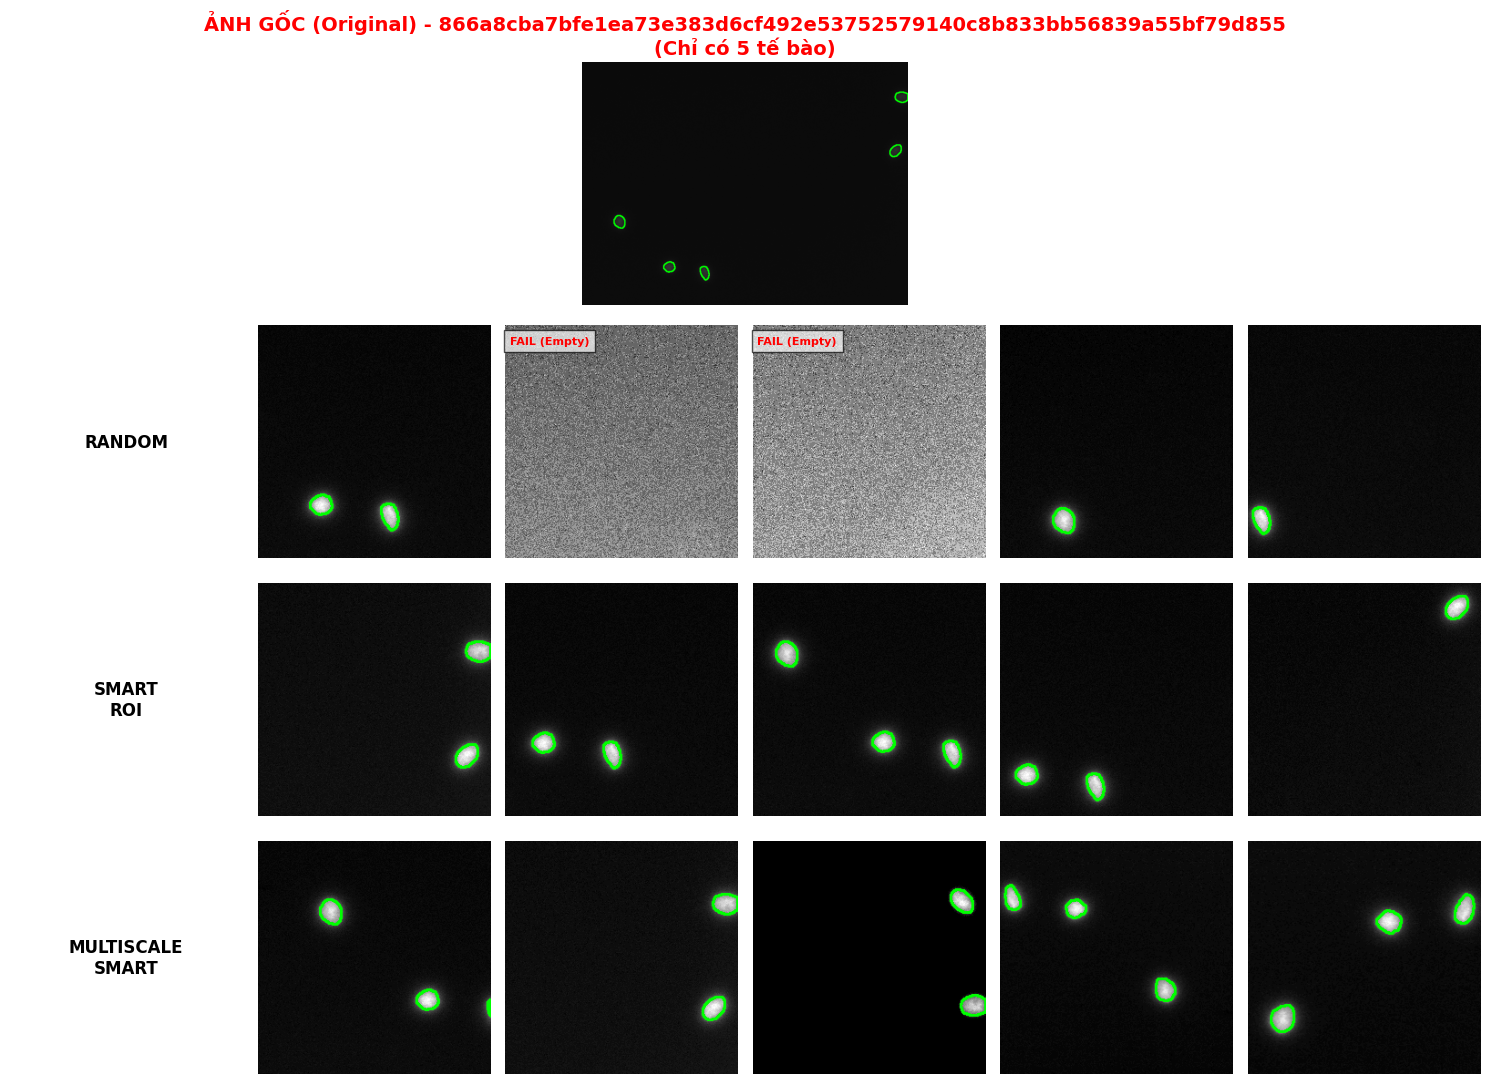

In [32]:
def find_sparsest_image_by_density(configs):
    print("🕵️ Đang quét tìm ảnh có MẬT ĐỘ TẾ BÀO THẤP NHẤT (Lowest Density)...")
    
    base_dir = configs[0].TRAIN_DIR
    min_density = 100.0 # Khởi tạo max (100%)
    target_id = None
    target_stats = {}
    
    all_ids = next(os.walk(base_dir))[1]
    
    for id_ in tqdm(all_ids, desc="Scanning Density"):
        path = os.path.join(base_dir, id_)
        img_path = os.path.join(path, 'images', id_ + '.png')
        mask_dir = os.path.join(path, 'masks')
        
        if os.path.exists(img_path) and os.path.exists(mask_dir):
            # Check kích thước ảnh > 256
            img_head = cv2.imread(img_path) # Đọc để lấy size
            if img_head is None: continue
            h, w = img_head.shape[:2]
            
            if h > 256 and w > 256:
                # Load và gộp mask để tính mật độ
                total_pixels = h * w
                nuclei_pixels = 0
                
                # Cách tính nhanh không cần load full ảnh
                for f in next(os.walk(mask_dir))[2]:
                    m = cv2.imread(os.path.join(mask_dir, f), cv2.IMREAD_GRAYSCALE)
                    if m is not None:
                        nuclei_pixels += np.sum(m > 0)
                
                # Tính mật độ %
                density = (nuclei_pixels / total_pixels) * 100
                
                # Điều kiện:
                # 1. Density phải > 0 (không lấy ảnh rỗng)
                # 2. Density phải nhỏ hơn mức kỷ lục hiện tại
                # 3. nuclei_pixels không quá bé (tránh nhiễu 1-2 pixel) -> Lấy > 50 pixel
                if 0 < density < min_density and nuclei_pixels > 50:
                    min_density = density
                    target_id = id_
                    target_stats = {'h': h, 'w': w, 'density': density, 'pixels': nuclei_pixels}

    if target_id is None:
        print("❌ Không tìm thấy ảnh phù hợp.")
        return

    print(f"\n✅ Đã tìm thấy 'HOANG MẠC' (Ảnh thưa nhất):")
    print(f"   🆔 ID: {target_id}")
    print(f"   📉 Mật độ: {target_stats['density']:.4f}% (Cực thấp!)")
    print(f"   📏 Kích thước: {target_stats['h']}x{target_stats['w']}")
    print(f"   ⚪ Tổng pixel tế bào: {target_stats['pixels']}")
    
    # Gọi hàm visualize
    visualize_specific_image(configs, target_id)

# --- CHẠY ---
find_sparsest_image_by_density(configs_to_test)

🔄 Đang xử lý quy trình visualize từng bước...


/tmp/ipykernel_9282/2303953930.py:29: UserWarning: Argument(s) 'value' are not valid for transform PadIfNeeded
  A.PadIfNeeded(min_height=cfg.IMG_SIZE, min_width=cfg.IMG_SIZE, border_mode=0, value=0),
/tmp/ipykernel_9282/2303953930.py:45: UserWarning: Argument(s) 'alpha_affine' are not valid for transform ElasticTransform
  A.ElasticTransform(alpha=1, sigma=20, alpha_affine=20, p=0.2),
/tmp/ipykernel_9282/2303953930.py:49: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(max_holes=3, max_height=8, max_width=8,
/tmp/ipykernel_9282/2303953930.py:57: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 30.0), p=0.1),


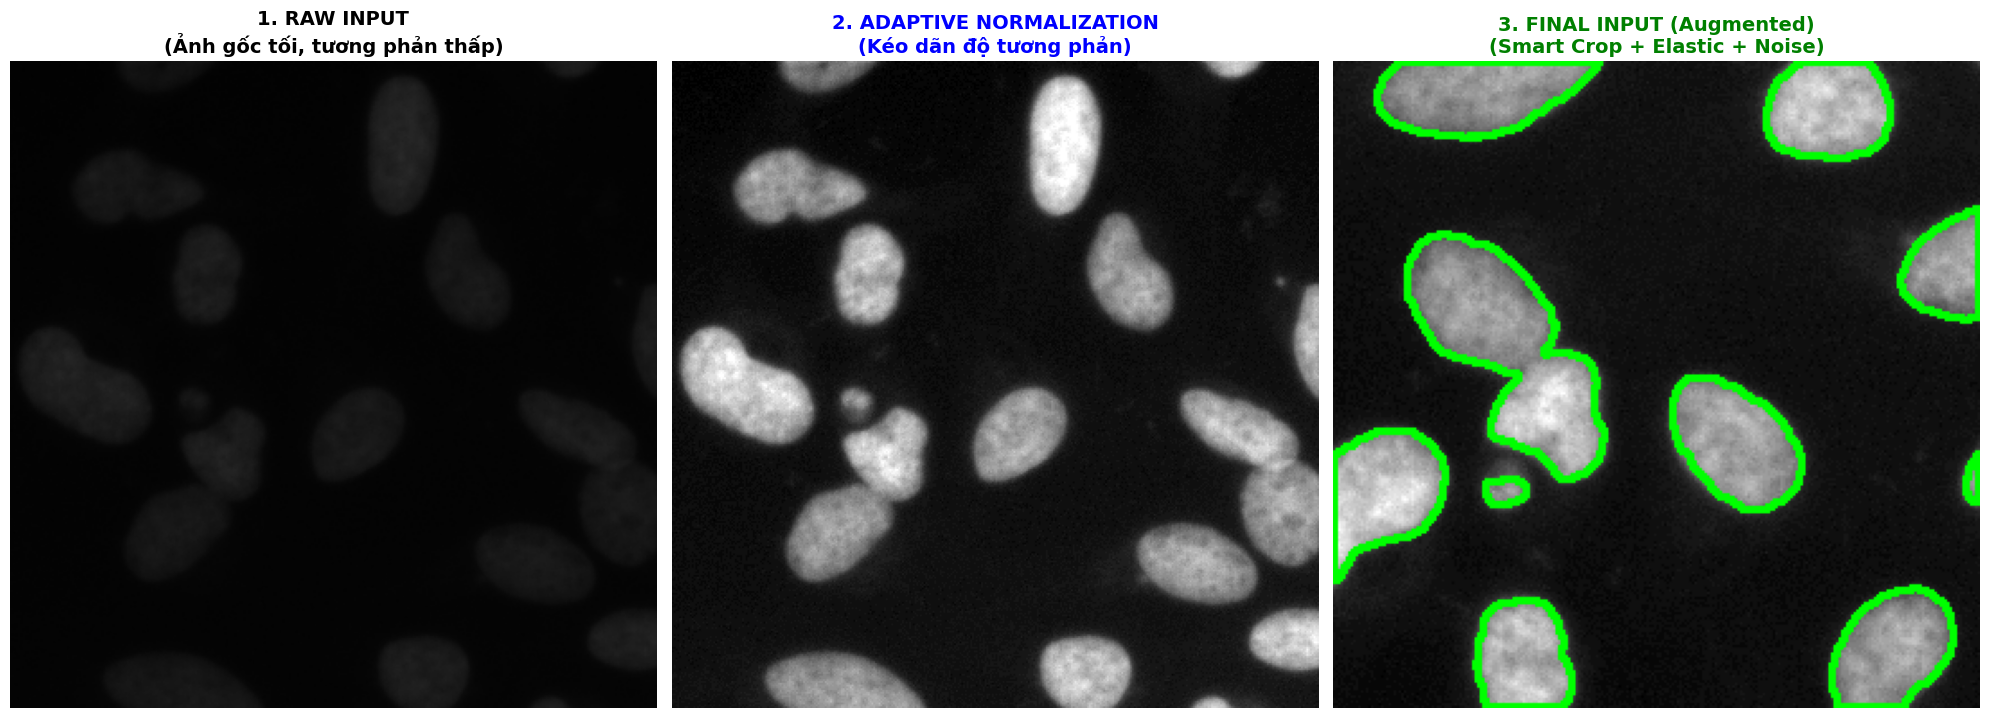

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import albumentations as A
import os

def visualize_preprocessing_steps(config, image_id=None):
    print("🔄 Đang xử lý quy trình visualize từng bước...")

    # 1. TÌM ẢNH (Nếu không đưa ID thì tìm ảnh nào có tế bào cho đẹp)
    base_dir = config.TRAIN_DIR
    if image_id is None:
        for id_ in next(os.walk(base_dir))[1]:
            mask_path = os.path.join(base_dir, id_, 'masks')
            if os.path.exists(mask_path) and len(next(os.walk(mask_path))[2]) > 10: # Lấy ảnh > 10 tế bào
                img_path = os.path.join(base_dir, id_, 'images', id_+'.png')
                # Lấy ảnh to chút để cắt cho rõ
                if cv2.imread(img_path).shape[0] > 300:
                    image_id = id_
                    break
    
    if image_id is None: 
        print("Không tìm thấy ảnh phù hợp"); return

    # 2. LOAD DỮ LIỆU THÔ
    img_path = os.path.join(base_dir, image_id, 'images', image_id+'.png')
    mask_dir = os.path.join(base_dir, image_id, 'masks')
    
    # Load ảnh gốc (Raw)
    raw_img = cv2.imread(img_path)
    raw_img = cv2.cvtColor(raw_img, cv2.COLOR_BGR2RGB)
    
    # Load Mask
    h, w = raw_img.shape[:2]
    mask = np.zeros((h, w), dtype=np.uint8)
    for f in next(os.walk(mask_dir))[2]:
        m = cv2.imread(os.path.join(mask_dir, f), 0)
        mask = np.maximum(mask, m)

    # 3. ĐỊNH NGHĨA HÀM CHUẨN HÓA (PERCENTILE NORMALIZATION)
    # Đây là hàm bạn viết trong báo cáo
    def adaptive_normalization(img):
        img = img.astype(np.float32)
        # Lấy phân vị 1% và 99.8%
        low = np.percentile(img, 1)
        high = np.percentile(img, 99.8)
        # Công thức chuẩn hóa
        img_norm = (img - low) / (high - low + 1e-7)
        img_norm = np.clip(img_norm, 0, 1) # Kẹp giá trị trong [0, 1]
        return (img_norm * 255).astype(np.uint8)

    # Bước 1: Ảnh sau khi chuẩn hóa
    norm_img = adaptive_normalization(raw_img)

    # Bước 2: Ảnh sau khi qua Augmentation (Cắt + Biến đổi)
    # Lấy transform từ config tốt nhất của bạn
    transform = get_transforms(config) 
    
    # Lưu ý: Albumentations thường tự normalize, nhưng ở đây ta làm thủ công
    # để visualize. Ta sẽ dùng transform lên ảnh đã normalize.
    aug = transform(image=norm_img, mask=mask)
    final_img_tensor = aug['image']
    final_mask_tensor = aug['mask']
    
    # Convert Tensor về Numpy để vẽ
    final_img = final_img_tensor.permute(1, 2, 0).numpy()
    final_img = (final_img - final_img.min()) / (final_img.max() - final_img.min()) # Min-max lại để hiển thị
    final_mask = final_mask_tensor.squeeze().numpy()

    # 4. VẼ BIỂU ĐỒ SO SÁNH (3 CỘT)
    fig, axes = plt.subplots(1, 3, figsize=(20, 7))
    
    # --- CỘT 1: ẢNH GỐC (RAW) ---
    axes[0].imshow(raw_img)
    axes[0].set_title(f"1. RAW INPUT\n(Ảnh gốc tối, tương phản thấp)", fontsize=14, fontweight='bold')
    axes[0].axis('off')
    # Vẽ histogram nhỏ bên dưới để thấy dải màu hẹp (Optional)
    
    # --- CỘT 2: SAU CHUẨN HÓA (NORMALIZED) ---
    axes[1].imshow(norm_img)
    axes[1].set_title(f"2. ADAPTIVE NORMALIZATION\n(Kéo dãn độ tương phản)", fontsize=14, fontweight='bold', color='blue')
    axes[1].axis('off')

    # --- CỘT 3: INPUT VÀO MODEL (FINAL CROP) ---
    # Vẽ viền mask lên ảnh
    overlay = (final_img * 255).astype(np.uint8).copy()
    contours, _ = cv2.findContours(final_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, contours, -1, (0, 255, 0), 2)
    
    axes[2].imshow(overlay)
    axes[2].set_title(f"3. FINAL INPUT (Augmented)\n(Smart Crop + Elastic + Noise)", fontsize=14, fontweight='bold', color='green')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# --- CHẠY THỬ ---
# Sử dụng config tốt nhất (Multiscale) để demo
visualize_preprocessing_steps(cfg_best)